In [33]:
%matplotlib inline

import numpy as np
from tqdm import tqdm
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset,GermanDataset,CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult,load_preproc_data_german,load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
        import get_distortion_adult,get_distortion_compas,get_distortion_german

from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools



from common_utils import compute_metrics
from IPython.display import Markdown,display
import matplotlib.pyplot as plt

### Load dataset and Specify Options

In [2]:
dataset_used='adult'
protected_attribute_used=1

if dataset_used=='adult':
    if protected_attribute_used==1:
        privileged_groups=[{'sex':1}]
        unprivileged_groups=[{'sex':0}]
        dataset_orig=load_preproc_data_adult(['sex'])
    else:
        privileged_groups=[{'race':1}]
        unprivilege_groups=[{'race':0}]
        dataset_orig=load_preproc_data_adult(['race'])
        
    optim_options={'distortion_fun':get_distortion_adult,
                  'epsilon':0.05,
                  'clist':[0.99,1.99,2.99],
                  'dlist':[.1,.05,0]}
elif dataset_used=='german':
    if protected_attribute_used==1:
        privileged_groups=[{'sex':1}]
        unprivileged_groups=[{'sex':0}]
        dataset_orig=load_preproc_data_german(['sex'])
    else:
        privileged_groups=[{'race':1}]
        unprivileged_groups=[{'race':0}]
        dataset_orig=load_preproc_data_german(['race'])
    optim_options={'distortion_fun':get_distortion_german,
                  'epsilon':0.05,
                  'clist':[0.99,1.99,2.99],
                  'dlist':[0.1,0.05,0]}
elif dataset_used=='compas':
    if protected_attribute_used==1:
        privileged_groups=[{'sex':1}]
        unprivileged_groups=[{'sex':0}]
        dataset_orig=load_preproc_data_compas(['sex'])
    else:
        privileged_groups=[{'race':1}]
        unprivileged_groups=[{'race':0}]
        dataset_orig=load_preproc_data_compas(['race'])
    optim_options={'distortion_fun':get_distortion_compas,
              'epsilon':0.05,
              'clist':[0.99,1.99,2.99],
              'dlist':[0.1,0.05,0]}
    
np.random.seed(0)
dataset_orig_train,dataset_orig_vt=dataset_orig.split([0.7],shuffle=True)
dataset_orig_validation,dataset_orig_test=dataset_orig_vt.split([0.5],shuffle=True)
        

### Display dataset attributes

In [3]:
# print out some labels,names,etc.
display(Markdown('#### Training Dataset shape'))
print(dataset_orig_train.features.shape)

display(Markdown('#### Favorable and unfavorable labels'))
print(dataset_orig_train.favorable_label,dataset_orig_train.unfavorable_label)

display(Markdown('#### Protected attributes name'))
print(dataset_orig_train.protected_attribute_names)

display(Markdown('#### Previleged and unprivileged protected attribute values'))
print(dataset_orig_train.privileged_protected_attributes,dataset_orig_train.unprivileged_protected_attributes)

display(Markdown('#### Dataset feature names'))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attributes name

['sex']


#### Previleged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


### Metric for orignal training dataset

In [4]:
# metric for the original dataset
metric_orig_train=BinaryLabelDatasetMetric(dataset_orig_train,
                                           privileged_groups=privileged_groups,
                                           unprivileged_groups=unprivileged_groups)
display(Markdown('#### Original training dataset'))
print('Difference in mean outcomes between unprivileged and privileged groups = %f'%metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.193075


### Train and transform the original training data

In [5]:
OP=OptimPreproc(OptTools,
               optim_options,
               unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
OP=OP.fit(dataset_orig_train)

dataset_transf_train=OP.transform(dataset_orig_train)
dataset_transf_train=dataset_orig_train.align_datasets(dataset_transf_train)

Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.

This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 

Optimized Preprocessing: Objective converged to 0.011652


### Metrics with the transformed train data

In [6]:
metric_transf_train=BinaryLabelDatasetMetric(dataset_transf_train,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown('#### Transformed training dataset'))
print('Difference in mean outcomes between unprivileged and privileged groups=%f'%metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups=-0.051548


In [7]:
#### Testing
assert np.abs(metric_transf_train.mean_difference())<np.abs(metric_orig_train.mean_difference())

### Load, clean up original test data and compute metric

In [8]:
dataset_orig_test=dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown('#### Testing Dataset shape'))
print(dataset_orig_test.features.shape)

metric_orig_test=BinaryLabelDatasetMetric(dataset_orig_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown('#### Original test dataset'))
print('Difference in mean difference between unprivileged and privileged groups =%f'%metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean difference between unprivileged and privileged groups =-0.199265


### Transform test data and compute metric

In [9]:
dataset_transf_test=OP.transform(dataset_orig_test,transform_Y=True)
dataset_transf_test=dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test=BinaryLabelDatasetMetric(dataset_transf_test,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)
display(Markdown('#### Transform test dataset'))
print('Difference in mean difference between unprivileged and privileged groups =%f'%metric_transf_test.mean_difference())

#### Transform test dataset

Difference in mean difference between unprivileged and privileged groups =-0.051017


In [10]:
#### Testing
assert np.abs(metric_transf_test.mean_difference())<np.abs(metric_orig_test.mean_difference())

### Train Classifier on transformed data and obtain predictions with its fairness metrics

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [12]:
scale_transf=StandardScaler()
X_train=scale_transf.fit_transform(dataset_orig_train.features)
y_train=dataset_orig_train.labels.ravel()

In [13]:
lmod=LogisticRegression()
lmod.fit(X_train,y_train)
y_train_pred=lmod.predict(X_train)

dataset_transf_train_pred=dataset_transf_train.copy()
dataset_transf_train_pred.labels=y_train_pred

In [14]:
pos_ind=np.where(lmod.classes_==dataset_orig_train.favorable_label)[0][0]
pos_ind

1

### Obtain Scores original test set

In [16]:
dataset_orig_valid_pred=dataset_orig_validation.copy(deepcopy=True)
X_valid=scale_transf.transform(dataset_orig_valid_pred.features)
y_valid=dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores=lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred=dataset_orig_test.copy(deepcopy=True)
X_test=scale_transf.transform(dataset_orig_test.features)
y_test=dataset_orig_test_pred.labels
dataset_orig_test_pred.scores=lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)


### Find the optimal classification threshold from the validation set

In [29]:
num_thresh=100
ba_arr=np.zeros(num_thresh)
class_thresh_arr=np.linspace(0.01,0.99,num_thresh)

for ind,class_thresh in enumerate(class_thresh_arr):
    fav_inds=dataset_orig_valid_pred.scores>class_thresh
    dataset_orig_valid_pred.labels[fav_inds]=dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds]=dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid=ClassificationMetric(dataset_orig_validation,
                                                     dataset_orig_valid_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
    ba_arr[ind]=0.5*(classified_metric_orig_valid.true_positive_rate()\
                    +classified_metric_orig_valid.true_negative_rate())
    
best_ind=np.where(ba_arr==np.max(ba_arr))[0][0]
best_class_thresh=class_thresh_arr[best_ind]

print('Best balance accuracy (no fairness contraints) =%.4f'%np.max(ba_arr))
print('Optimal classification threshold (no fairness constraints)=%.4f'%best_class_thresh)

Best balance accuracy (no fairness contraints) =0.7414
Optimal classification threshold (no fairness constraints)=0.2674


invalid value encountered in double_scalars


### Predictions and fairness metrics from original testset

In [30]:
display(Markdown("#### Predictions from original testing dataset"))
bal_acc_arr_orig=[]
disp_imp_arr_orig=[]
avg_odds_diff_arr_orig=[]

display(Markdown('#### Testing set'))
display(Markdown('#### Raw predictions - No fairnes constraints'))

for thresh in tqdm(class_thresh_arr):
    fav_inds=dataset_orig_test_pred.scores>thresh
    dataset_orig_test_pred.labels[fav_inds]=dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds]=dataset_orig_test_pred.unfavorable_label
    
    if(thresh==best_class_thresh):
        disp=True
    else:
        disp=False
    
    metric_test_bef=compute_metrics(dataset_orig_test,dataset_orig_test_pred,
                                   unprivileged_groups,privileged_groups,disp)
    
    bal_acc_arr_orig.append(metric_test_bef['Balanced accuracy'])
    avg_odds_diff_arr_orig.append(metric_test_bef['Average odds difference'])
    disp_imp_arr_orig.append(metric_test_bef['Disparate impact'])

#### Predictions from original testing dataset

#### Testing set

#### Raw predictions - No fairnes constraints

 69%|███████████████████████████████████████████████████████▏                        | 69/100 [00:00<00:00, 225.54it/s]

Balanced accuracy = 0.7463
Statistical parity difference = -0.3536
Disparate impact = 0.2836
Average odds difference = -0.2795
Equal opportunity difference = -0.2947
Theil index = 0.1095


invalid value encountered in double_scalars
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 223.83it/s]


0.716427035412478


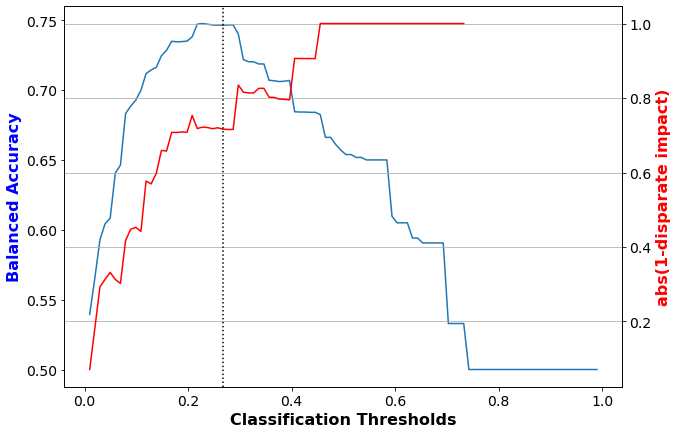

In [43]:
fig,ax1=plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr,bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds',fontsize=16,fontweight='bold')
ax1.set_ylabel('Balanced Accuracy',fontsize=16,fontweight='bold',c='b')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2=ax1.twinx()
ax2.plot(class_thresh_arr,np.abs(1.0-np.array(disp_imp_arr_orig)),color='r')
ax2.set_ylabel('abs(1-disparate impact)',color='r',fontsize=16,weight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
           color='k',linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
disp_imp_at_best_bal_acc_orig=np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]
print(disp_imp_at_best_bal_acc_orig)

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [44]:
scale_transf=StandardScaler()
X_train=scale_transf.fit_transform(dataset_transf_train.features)
y_train=dataset_transf_train.labels.ravel()

lmod=LogisticRegression()
lmod.fit(X_train,y_train)
y_train_pred=lmod.predict(X_train)

dataset_transf_train_pred=dataset_transf_train.copy()
dataset_transf_train_pred.labels=y_train_pred

### Predictions and fairness metrics from transformed testset

In [46]:
dataset_transf_test_pred=dataset_transf_test.copy(deepcopy=True)
X_test=scale_transf.transform(dataset_transf_test_pred.features)
y_test=dataset_transf_test_pred.labels
dataset_transf_test_pred.scores=lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [48]:
display(Markdown('#### Predictions from the transformed test data'))
bal_acc_arr_transf=[]
disp_imp_arr_transf=[]
avg_odds_diff_arr_transf=[]

display(Markdown('#### Testing set'))
display(Markdown('#### Transformed predictions - No fairness constraints'))
for thresh in tqdm(class_thresh_arr):
    fav_inds=dataset_transf_test_pred.scores>thresh
    dataset_transf_test_pred.labels[fav_inds]=dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds]=dataset_transf_test_pred.unfavorable_label
    
    if thresh==best_class_thresh:
        disp=True
    else:
        disp=False
        
    metric_test_bef=compute_metrics(dataset_transf_test,
                                   dataset_transf_test_pred,
                                   unprivileged_groups,
                                   privileged_groups,
                                   disp)
    
    bal_acc_arr_transf.append(metric_test_bef['Balanced accuracy'])
    disp_imp_arr_transf.append(metric_test_bef['Disparate impact'])
    avg_odds_diff_arr_transf.append(metric_test_bef['Average odds difference'])

#### Predictions from the transformed test data

#### Testing set

#### Transformed predictions - No fairness constraints

 70%|████████████████████████████████████████████████████████                        | 70/100 [00:00<00:00, 230.40it/s]

Balanced accuracy = 0.6969
Statistical parity difference = -0.0757
Disparate impact = 0.8069
Average odds difference = -0.0706
Equal opportunity difference = -0.0975
Theil index = 0.1372


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 229.87it/s]


0.19312249656244396


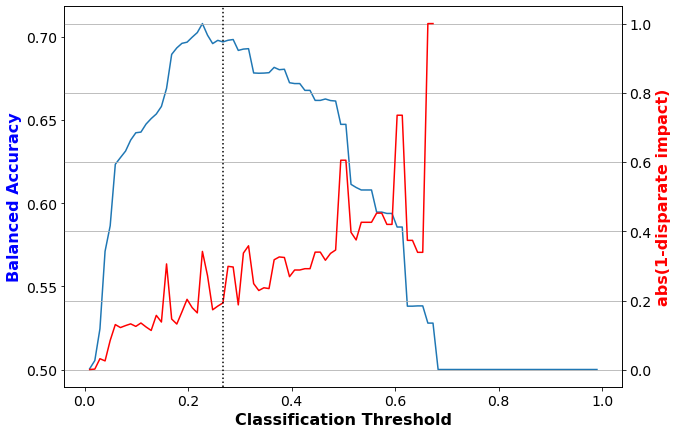

In [60]:
fig,ax1=plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr,bal_acc_arr_transf)
ax1.set_xlabel('Classification Threshold',fontsize=16,fontweight='bold')
ax1.set_ylabel('Balanced Accuracy',fontsize=16,fontweight='bold',color='b')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2=ax1.twinx()
ax2.plot(class_thresh_arr,np.abs(1.0-np.array(disp_imp_arr_transf)),color='r')
ax2.set_ylabel('abs(1-disparate impact)',fontsize=16,fontweight='bold',color='r')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
ax2.axvline(np.array(class_thresh_arr)[best_ind],
           color='k',linestyle=':')
disp_imp_at_best_bal_acc_transf=np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]
print(disp_imp_at_best_bal_acc_transf)

### Predictions and fairness metrics from transformed test set

In [ ]:
dataset_transf_test_pred=dataset_transf_test.copy(deepcopy=True)
X_test=scale_transf.transform(dataset_transf_test_pred.features)
y_test=dataset_transf_test_pred.labels
dataset_transf_test_pred.scores=lmod.predict_proba(X_test)[:,]

In [35]:
y_train_pred

array([1., 1., 1., ..., 0., 0., 0.])

In [36]:
lmod.classes_==da

array([0., 1.])

In [31]:
dataset_orig_train.labels

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])